### 딥러닝을 위한 고급 도구
이번 Post에서는 특정 문제에 대해서 강점을 보이는 Network가 아닌 Keras를 좀 더 잘 사용하기 위한 방법을 알아보는 Post이다.  
<br>

#### 필요한 라이브러리 Import

In [2]:
from keras.models import Model
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import Input
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.utils import plot_model
import cv2
from keras.layers import Flatten, Dense, Embedding
from keras.models import Sequential

### Sequential 모델을 넘어서: 케라스의 함수형 API
비교를 하기 위해서 먼저 기본적인 Sequencial의 Model부터 살펴보자.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/46.png" height="250" width="300" /></div><br>
사진 출처: <a href="https://subinium.github.io/Keras-7/#716-%EC%B8%B5%EA%B3%BC-%EB%AA%A8%EB%8D%B8">subinium 블로그</a><br>

위의 구조를 간단하게 표현아면 아래와 같다.

In [3]:
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
None


위와 같은 Sequencial한 Model의 구조로서 이전 Post들에서는 많은 문제를 해결하였다.  
하지만 다음과 같은 Model의 구조를 필요로 할때는 Keras에서 제공하는 Sequential한 Model만으로는 해결하지 못한다.  

**1. 다중 입력이 필요한 Model**  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/47.png" height="250" width="600" /></div><br>
사진 출처: <a href="https://subinium.github.io/Keras-7/#716-%EC%B8%B5%EA%B3%BC-%EB%AA%A8%EB%8D%B8">subinium 블로그</a><br>
CNN과 RNN만을 비교해 봐도 입력 Data의 Format에 따라서 강점을 가지고 있다.  
따라서, Text와 Image를 Input으로 들어오게 되었을때 서로 다른 Layer를 거친 뒤 합쳐지는 다중 입력이 필요한 Model인 경우 Sequential한 Model로만은 문제를 해결할 수 없을 것 이다.  
<br>

**2. 다중 출력이 필요한 Model**  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/48.png" height="250" width="600" /></div><br>
사진 출처: <a href="https://subinium.github.io/Keras-7/#716-%EC%B8%B5%EA%B3%BC-%EB%AA%A8%EB%8D%B8">subinium 블로그</a><br>
어떤 Input Data가 들어오게 되었을때 여러개의 Target Data를 측정하는 것 또한 Sequential한 Model만으로는 불가능 하다.  
위의 사진처럼 예를들어 소설 텍스트가 Input으로 들어왔을때 장르와 시대 2가지의 Target 으로 결과를 출력하는 Model은 Sequentail한 Model만으로는 불가능하다.  

<br>

**3. 층으로 구성되 유황 비순환 그래프**  
>유향 비순환 그래프(directed acyclic graph, DAG, 유향 비사이클 그래프), 방향 비순환 그래프(방향 비사이클 그래프, 방향성 비사이클 그래프)는 수학, 컴퓨터 과학 분야의 용어의 하나로서 방향 순환이 없는 무한 유향 그래프이다. 즉, 무한히 수많은 꼭짓점과 간선으로 구성되며 각 간선은 하나의 꼭짓점에서 다른 꼭짓점으로 방향을 잇는데 이처럼 어떠한 꼭짓점 v에서 시작하여 끝내 다시 v로 돌아가 순환 반복되는 일정한 방향의 일련한 간선을 따라가는 방법이 없다.

<img alt="" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Topological_Ordering.svg/220px-Topological_Ordering.svg.png">
출처: <a href="https://ko.wikipedia.org/wiki/%EC%9C%A0%ED%96%A5_%EB%B9%84%EC%88%9C%ED%99%98_%EA%B7%B8%EB%9E%98%ED%94%84">위키백과</a>

대표적인 예로 아래 그림과 같은 Inception Module과 같은 구조가 있다.  
<img src="https://user-images.githubusercontent.com/25279765/35002517-441c8166-fb2d-11e7-9b40-b4216256cbb0.jpg" width="500" height="300"><br>
**최근에 개발된 많은 신경망 구조는 선형적이지 않는 네트워크 토폴로지(topology)가 필요하다.**  
따라서 이러한 구조도 Sequential한 Model만으로는 표현이 불가능하다는 것을 알 수 있다.  

#### 함수형 API 소개
함수형 API(functioanl API)에서는 직접 텐서들의 입출력을 다룬다. 함수처럼 층을 사용하여 텐서를 입력받고 출력하는 것을 함수형 API라고 불린다.  
아래 Code를 살펴보게 되면 **Keras는 Input Tensor와 Output Tensor를 입력으로 주어 Model을 구성하게되면 Input Tensor -> Output Tensor까지 가는 모든 Layer를 모아서 Model로서 만든다.**  

In [7]:
input_tensor = Input(shape=(64,))
x = layers.Dense(32,activation='relu')(input_tensor)
x = layers.Dense(32,activation='relu')(x)
output_tensor = layers.Dense(10,activation='softmax')(x)

model = Model(input_tensor,output_tensor)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


위와 같이 함수형 API를 사용하는 경우에는 Input Tensor -> Output Tensor까지 가는모든 Layer를 모아서 Model로 만들기 때문에 Input_tensor를 변환하여 Output Tensor로 갈 수 있어야 한다.  
아래 Code는 <code>x = layers.Dense(32,activation='relu')(input_tensor)</code>로서 Input Tensor의 Input을 64로 제한하였지만 128의 Input을 사용하려고 하여 Input Tensor가 변환이 되지 않아서 Error가 발생한다.

In [9]:
unrelate_input = Input(shape=(128,))
bad_model = Model(unrelate_input,output_tensor)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_2:0", shape=(?, 64), dtype=float32) at layer "input_2". The following previous layers were accessed without issue: []

#### 다중 입력 Model
위에서 Sequential한 Model로서 표현할 수 없는 1번째의 경우이다.  
Sequential한 Model이 아닌 함수형 API를 사용하여 Model을 구축할 수 있다.  
Keras또한 Tensorflow와 마찬가지로 서로 다른 Output의 Tensor를 합치기 위하여 <code>keras.layers.add</code>나 <code>keras.layers.concatenate</code>등을 사용하여 구축한다.  

다중 입력 Model로서 구현하고자하는 Model은 다음과 같다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/49.png" height="250" width="600" /></div><br>
사진 출처: <a href="https://subinium.github.io/Keras-7/#716-%EC%B8%B5%EA%B3%BC-%EB%AA%A8%EB%8D%B8">subinium 블로그</a><br>

Model의 구조는 크게 다음과 같다.
1. 참고 텍스트와 질문 2개의 다중 입력을 받는다.
2. 각각의 Data에 맞는 Embedding Layer와 LSTM을 구성한다.
3. <code>keras.layers.concatenate</code>을 사용하여 결과 Tensor를 하나로 합친다.
4. DenseLayer에서 Softmax를 통하여 한 단어로 된 답을 출력한다.



In [18]:
# Hyperparameter 선언
text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 1번째 부분 Network를 선언합니다. 참고 Text -> Embedding -> LSTM
text_input = Input(shape=(None, ), dtype='int32', name='text')
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)
encoded_text = layers.LSTM(32)(embedded_text)

# 2번째 부분 Network를 선언합니다. 질문 -> Embedding -> LSTM
question_input = Input(shape=(None, ), dtype='int32', name='question')
embedded_question = layers.Embedding(question_vocabulary_size, 64)(question_input)
encoded_question = layers.LSTM(32)(embedded_question)

# 부분 Network를 하나로 합칩니다.
concatenated = layers.concatenate([encoded_text, encoded_question])

# Softmax로서 결과를 출력합니다.
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

# 다중 입력이므로 Input을 []로 감싸서 2개를 대입합니다.
model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 64)     640000      question[0][0]                   
____________________________________________________________________________________________

위의 결과를 확인하면 이태까지의 Model과 다른 결과를 확인할 수 있다.  
**Model Summary에서 알 수 있는것은 Model을 구성하는 Depth에 따라서 보기 쉽게 출력된다는 사실과 이태까지 볼 수 없었던 Connected to를 통하여 어떤 Layer끼리 연결되었는지 제공한다는 것 이다.**  

만들어진 Model에 Random하게 Data를 만들어서 실제로 Training되는 지 확인하자.  
<br>

**참고 사항**  
이태까지는 그냥 Data를 Input으로 넣었으나 다중 입력 Model을 선언하였으므로 어떤 Model에 어떤 Data를 넣을지 Matching해서 넣을 수 있다.  
즉, Data를 Model에 넣는 방법은 2가지가 있다.  
1. Numpy 배열로 이루워진 딕셔너리를 Model의 입력으로 주입한다.
2. 입력 이름과 배열로 이루워진 딕셔너리를 모델의 입력으로 주입

2번의 과정으로 Code를 구성한다.  
위에서 Input을 살펴보면 <code>text_input = Input(shape=(None, ), dtype='int32', name='text')</code>로서 name으로서 Keras에서 구분할 수 있게 선언하였으므로 입력 이름과 배열로 이루워진 딕셔너리를 Model의 Input으로서 사용할 수 있다.

In [19]:
num_samples = 1000
max_length = 100

# 입력으로 사용할 Data를 Random하게 Shpae를 맞춰서 선언한다.
text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))

# Target Data를 원핫 인코딩을 통하여 구성한다.
answers = np.random.randint(0, answer_vocabulary_size, size=num_samples)
answers = to_categorical(answers)

# 1.리스트 입력 사용
#model.fit([text, question], answers, epochs=10, batch_size=128)

# 2. 딕셔너리 입력을 사용하여 학습
model.fit({'text':text, 'question':question}, answers, epochs=10, batch_size=128)

Epoch 1/10
1000/1000 [==============================] - 1s 761us/step - loss: 6.2149 - acc: 0.0010
Epoch 2/10
1000/1000 [==============================] - 0s 377us/step - loss: 6.1923 - acc: 0.0630
Epoch 3/10
1000/1000 [==============================] - 0s 364us/step - loss: 6.1184 - acc: 0.0070
Epoch 4/10
1000/1000 [==============================] - 0s 406us/step - loss: 6.0196 - acc: 0.0060
Epoch 5/10
1000/1000 [==============================] - 0s 380us/step - loss: 5.9006 - acc: 0.0080
Epoch 6/10
1000/1000 [==============================] - 0s 460us/step - loss: 5.7665 - acc: 0.0380
Epoch 7/10
1000/1000 [==============================] - 0s 432us/step - loss: 5.6560 - acc: 0.0640
Epoch 8/10
1000/1000 [==============================] - 0s 367us/step - loss: 5.5700 - acc: 0.0660
Epoch 9/10
1000/1000 [==============================] - 0s 364us/step - loss: 5.5028 - acc: 0.0810
Epoch 10/10
1000/1000 [==============================] - 0s 393us/step - loss: 5.4186 - acc: 0.0800


#### 다중 출력 Model
위에서 Sequential한 Model로서 표현할 수 없는 2번째의 경우이다.  
Sequential한 Model이 아닌 함수형 API를 사용하여 Model을 구축할 수 있다.  

다중 출력 Model로서 구현하고자하는 Model은 다음과 같다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/50.png" height="250" width="600" /></div><br>
사진 출처: <a href="https://subinium.github.io/Keras-7/#716-%EC%B8%B5%EA%B3%BC-%EB%AA%A8%EB%8D%B8">subinium 블로그</a><br>

In [22]:
# Hyperparameter 선언
vocabulary_size = 50000
num_income_groups = 10

# 공통되는 Network 선언 위의 그림에서는 간단한 Convolution 1D로서 구현한다 되어있으나 CNN Network로서 선언하였다.
# 위의 그림에서 소설 미디어 포스트 -> 1D 컨브넷에 해당한다.
post_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size,256)(post_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

# 각각의 출력층을 선언한다.

# 1D 컨브넷 -> Dense -> 나이
age_prediction  = layers.Dense(1, name='age')(x)
# 1D 컨브넷 -> Dense -> 소득
income_prediction = layers.Dense(num_income_groups, activation='softmax', name='income')(x)
# 1D 컨브넷 -> Dense -> 성별
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(post_input, [age_prediction, income_prediction, gender_prediction])

model.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    163968      embedding_8[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, None, 128)    0           conv1d_1[0][0]                   
___________________________________________________________________________________________

위의 Model과 같이 다중 출력 Model일 경우에 크게 생각해야 하는 주의사항은 2가지이다.  
**1. 네트워크 출력마다 다른 손실 함수를 지정해야 한다.**  
예를들어 나이 예측은 스칼라 회귀 문제이지만 성별 예측은 이진 클래스 문제라 훈련 방식이 다릅니다. 경사 하강법은 하나의 스칼라 값을 최소화하기 때문에 모델을 훈련하려면 이 손실들을 하나의 합으로 합쳐야 합니다.  

**2. Loss에 Weight 지정**  
위에서 손실들의 값을 그대로 합친다고 가정해보자.  
만약 나의 회귀 작업에 사용되는 평균 제곱 오차(MSE)가 3 ~ 5 값이라고 가정한다면 성별 분류에서 사용되는 크로스엔트로피(binary_crossentroypy)는 보통 0 ~ 1 정도로 매우 낮습니다.  
따라서 Loss를 하나로 합치기 이전에 각각의 Loss에 Weight를 부여하는 과정이 필요하다.  

케라스에서는 compile 메서드에 딕셔너리를 사용하여 출력마다 다른 손실을 지정할 수 있다.

In [24]:
# 1. 리스트로 손실함수 지정 + 가중치
#model.compile(optimizer='rmsprop', loss=['mse','categorical_crossentropy', 'binary_crossentroypy'], loss_weights=[0.25, 1., 10.])

# 2. 딕셔너리로 손실함수 지정 + 가중치
model.compile(optimizer='rmsprop', loss={'age':'mse', 'income':'categorical_crossentropy', 'gender':'binary_crossentropy'}, loss_weights={'age':0.25, 'income':1., 'gender':10.})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### 층으로 구성되 유황 비순환 그래프
위에서 Sequential한 Model로서 표현할 수 없는 3번째의 경우이다.  
Sequential한 Model이 아닌 함수형 API를 사용하여 Model을 구축할 수 있다.  

구성하고자 하는 Module은 Inception Module이다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/51.png" height="100%" width="100%" /></div><br>
사진 출처: <a href="https://subinium.github.io/Keras-7/#716-%EC%B8%B5%EA%B3%BC-%EB%AA%A8%EB%8D%B8">subinium 블로그</a><br>

**참고 사항**  
이미 Keras에서 InceptionV3 Module을 <code>keras.applications.inception_v3.InceptionV3</code>통하여 사용할 수 있다.(Hyperparameter Tuning 되어있는 상태)  
아래 Code는 함수형 API를 통하여 이런 유황 비순환 그래프 구조도 구성할 수 있구나에 대해서만 파악하자.  
아래 Code에서 각각의 branch_a ~ branch_d는 위의 그림에서 왼쪽부터 오른쪽으로 Matching해서 생각하면 된다.  
Inception구조에 대해 Parameter의 의미를 자세히 알고싶으면 링크를 참조하자: <a href="https://wjddyd66.github.io/pytorch/Pytorch-CNN2/#googlenet-implementation">Pytorch-CNN2</a>

In [37]:
# Input_tensor 선언: Model을 구성하고 summary시 결과 확인을 위하여 임의의 크기 Color Input이라고 생각하고 선언
input_tensor = Input(shape=(224,224,3))

# branch_a 선언
branch_a = layers.Conv2D(128,1,activation='relu',strides=2)(input_tensor)

# branch_b 선언
branch_b = layers.Conv2D(128,1,activation='relu')(input_tensor)
branch_b = layers.Conv2D(128,3,activation='relu',strides=2, padding='same')(branch_b)

# branch_c 선언
branch_c = layers.AveragePooling2D(3,strides=2, padding='same')(input_tensor)
branch_c = layers.Conv2D(128,3,activation='relu', padding='same')(branch_c)

# branch_d 선언
branch_d = layers.Conv2D(128,1,activation='relu')(input_tensor)
branch_d = layers.Conv2D(128,3,activation='relu', padding='same')(branch_d)
branch_d = layers.Conv2D(128,3,activation='relu',strides=2, padding='same')(branch_d)

# Output 선언
output_tensor = layers.concatenate([branch_a,branch_b,branch_c,branch_d],axis=-1)

model = Model(input_tensor,output_tensor)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 224, 224, 128 512         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 224, 224, 128 512         input_15[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_10 (AveragePo (None, 112, 112, 3)  0           input_15[0][0]                   
____________________________________________________________________________________________

**가중치 공유**  
함수형 API에서는 층 객체를 여러번 사용할 수 있다는 것 이다.  
층 객체를 두 번 호출하면 새로운 층 객체를 만들지 않고 각 호출에 동일한 가중치를 재사용한다.  
이런 기능 때문에 공유 가지를 가진 Model을 만들 수 있다.  
>예를 들어 두 문장 사이의 의미가 비슷한지 측정하는 모델을 만든다고 가정하자.  
이 모델은 2개의 입력을 받고 0 ~ 1 사이의 점수를 출력한다.  
0은 관련 없는 문장을 의미하고 1은 두 문장이 동일하거나 재구성 되었다는 것을 의미한다.  
이런 모델은 대화 시스템에서 자연어 질의에 대한 중복 제거를 포함하여 많은 애플리케이션에서 유용하게 사용 된다.  
이러한 문제에서는 두 입력 시퀀스가 바뀔 수 있다.  
의미가 비슷하다는 것은 대칭적인 관계이기 때문이다.  
A에서 B에 대한 유사도는 B에서 A에 대한 유사도와 같다.  
이런 이유 때문에 각 입력 문장을 처리하는 2개의 독립된 모델이 아닌 가중치가 같은 1개의 모델로서 구성하는 것이 맞다
>


In [38]:
# 가중치를 공유할 1개의 LSTM
lstm = layers.LSTM(32)

# 공유하는 LSTM을 통하여 Branch를 하나 생성한다.
left_input = Input(shape=(None,128))
left_output = lstm(left_input)

# 공유하는 LSTM을 통하여 Branch를 하나 생성한다.
right_input = Input(shape=(None,128))
right_output = lstm(right_input)

# 두 Branch LSTM Model을 합쳐서 1개의 Model로서 구성합니다.
merged = layers.concatenate([left_output,right_output],axis=-1)
predictions = layers.Dense(1,activation='sigmoid')(merged)

#Model을 구성하고 확인합니다.
model = Model([left_input,right_input],predictions)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 32)           20608       input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 64)           0           lstm_7[0][0]               

### 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링
<code>model.fit()</code>이나 <code>model.fit_generator()</code>로 Epoch수만큼 Training하는 동안 우리가 얻을 수 있는 정보는 metrics=[]에 정의한 특정 Object에 대하여 값이 얼만큼 나와있는지 확인하는 것 이다.  
**이러한 Training과정에서 사용자가 특별하게 Training과정을 Customize할 수 있게 도와주는 것이 콜백이다.**  
다음 4가지의 경우는 대표적으로 콜백을 사용하는 예시이다.
1. 모델 체크포인트 저장: 훈련하는 동안 어떤 지점에서 모델의 현재 가중치를 저장한다.(Tensorflow에서 log를 남기는 것과 같습니다.)
2. 조기 종료(early stopping): 검증 손실이 더 이상 향상되지 않을 때 훈련을 중지합니다.(물론 훈련하는 동안 얻은 가장 좋은 모델을 저장한다.)
3. 훈련하는 동안 하이퍼파라미터 값을 동적으로 조정합니다: 옵티마이저의 학습률이 같은 경우이다.
4. 훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될 때마다 시각화한ㄷ.(앞서 보았던 케라스의 진행 표시줄(progress bar)이 하나의 콜백이다.)

CallBack에 내장되어있는 모듈은 많다. 따라서 옆의 링크를 참조하자. <a href="https://keras.io/ko/callbacks/">Keras callbak 사용법 사이트</a><br>  

Keras에서 제공하는 콜백 중에서 ReduceLRONPlateau CallBack을 사용하여 보자.  
<br>

#### ReduceLRONPlateau 콜백
ReduceLRONPlateau은 검증 손실이 향상되지 않을 때 학습률을 작게 할 수 있다.  
손실 곡선이 평탄할 때 학습률을 작게하거나 크게 하면 훈련도중 Local Minima나 Plateau같은 상황에서 벗어나는데 도움을 줄 수 있다.  
아래 Code와 같이 collback을 선언하고 model.fit()에 callbacks Parameter에 지정하면 된다.  

**참고 사항**  
Local Minima나 Plateau는 Optimizer를 지정할 때 고려되는 매우 중요한 요소입니다.  
<a href="https://wjddyd66.github.io/dl/NeuralNetwork-(3)-Optimazation2/">NeuralNetwork (3) Optimazation2</a>를 보고 어떠한 요소인지 한번 정도 파악할 필요가 있습니다. (수식까지는 필요없습니다. 이미 다 구현되어서 사용하면 됩니다.)

In [ ]:
callback_list = [
  keras.callbacks.ReduceLRONPlateau(
    monitor='val_acc',
    factor=0.1, # 콜백이 호출되면 학습률을 10배로 줄임
    patience=10,
  )
]

# 지정한 Callback model.fit()에 적용하기
model.fit(x,y,epochs=10, batch_size=32, callbacks=callback_list)

#### 자신만의 콜백 만들기 & Tensorboard
Tensorboar는 텐서플로 라이브러리로서 학습 결과를 시각화해서 보여주는 강력한 도구이다.  
Tensorflow에서의 사용법은 링크를 참조하자. <a href="https://wjddyd66.github.io/tensorflow/Tensorflow-Baisc/">Tensorflow-Baisc</a>  
이러한 Tensorboard또한 Keras의 Callback을 사용하여 쉽게 사용할 수 있다.  

또한 Keras에서 제공하지 않는 Callback은 사용자가 Customizing하여 사용할 수 있다.  
이러한 Callback은 keras.callbacks.Callback 클래스를 상속받아 구현하고 훈련하는 동안 호출된 여러 지점을 나타내기 위해 약속된 다음 메서드를 구현한다.  아래 Method는 logs 매개변수와 함깨 호출된다. logs는 이전 배치, 에포크에 대한 훈련과 검증 측정값이 담겨 있는 딕셔너리가 전달된다.  

- on_epoch_begin: 각 에포크가 시작할 때 호출
- on_epoch_end: 각 에포크가 끝날 때 호출
- on_batch_begin: 각 배치 처리가 시작되기 전에 호출
- on_batch_end: 각 배치 처리가 끝날 때 호출
- on_train_begin: 훈련이 시작할 때 호출
- on_train_end: 훈련이 끝날 때 호출

또한 콜백은 다음 속성을 참조할 수 있다.  
- self.model: 콜백을 호출하는 모델 객체
- self.validation_data: fit() 메서드에 전될된 검증 데이터

아래 선언한 콜백은 각 Epoch가 끝날때 Tensorboard에 Log를 남기고 결과를 확인한다.

In [3]:
# Text 처리를 위한 ANN Network선언
max_features = 10000
maxlen = 20

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)
x_train = pad_sequences(x_train,maxlen=maxlen)
x_test = pad_sequences(x_test,maxlen=maxlen)

model = Sequential()
model.add(Embedding(10000,8,input_length=maxlen))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

        
# 선언되어 있는 Tensorboard 콜백을 사용한다.
callbacks = [
  keras.callbacks.TensorBoard(
    log_dir='my_log_dir', # 저장될 path
    histogram_freq=1, # 1 에포크마다 활성화 출력의 히스토그램을 기록
    embeddings_freq=1, # 1 에포크마다 임베딩 데이터를 기록
    embeddings_data = x_train, # 임베딩 데이터를 선언해야 한다.
  )
]

hitory = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________

Train on 20000 samples, validate on 5000 samples






Epoch 1/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6880 - acc: 0.5687 - val_loss: 0.6773 - val_acc: 0.6474

Epoch 2/20
20000/20000 [==============================] - 0s 10us/step - loss: 0.6443 - acc:

Log를 남기면서 Training이 진행되기 때문에 평소보다 느기레 Training이 되었지만, my_log_dir Directory에서 <code>tensorboard --logdir = ./</code>로서 Tensorboard를 확인하면 다음가 같은 결가를 얻을 수 있다.  

**acc, loss확인**  
Keras는 기본적으로 Training되면서 loss와 acc를 log에 남기게 된다. 이로 인하여 우리는 callback기능 중 하나인 progress bar를 확인하면서 Training결과를 확인할 수 있는 것 이다.  
Validation Option을 주어서 Training Dataset, Validation Dataset에 대한 acc와 loss를 Tensorboard에서 확인하면 다음과 같다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/52.png" height="100%" width="100%" /></div><br><br>

**Graph 확인**  
개인적으로 생각하는 **Tensorflow 장점은 Define and Run 구조를 가진다는 거 이다**  
즉, Graph를 Training전에 구성하고 진행하게 되면서 Graph의 Hyperparameter를 Tuning하게 되는 것이고 이렇게 정적인 Graph구조를 가지므로 Google Protocol Buffer를 사용하여 통신하거나 Serving에서 매우 강점을 가지는 언어라고 생각이 든다.  
Tensorflow와 같이 Keras에서도 이러한 Graph를 Tensorboard에서 확인 가능하다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/53.png" height="100%" width="100%" /></div><br><br>

**Histogram 확인**  
위에서 Tensorboard callback을 선언할 때 <code>histogram_freq=1</code> Option을 사용항 Histogram을 남겼다.  
결과는 역시 Tensorboard에서 확인할 수 있다.  
Tensorboard로서 Histogram은 처음 확인하는데 각각의 Layer에 관하여 결과를 보여주는데 정확한 해석은 못하겠다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/54.png" height="100%" width="100%" /></div><br><br>

**Embedding 확인**  
위에서 Tensorboard callback을 선언할 때 <code>embeddings_freq=1</code>, <code>embeddings_data = x_train</code> Option을 사용항 Embedding 결과를 남겼다.    
결과는 역시 Tensorboard에서 확인할 수 있다.  
**매우 흥미로웠던 점은 160차원(8 x max_len)의 Embedding에서 Tensorboard자체에서 Data의 분포를 쉽게 확인하기 위하여 PCA나 T-SNE로서 Visualization을 해준다는 것 이다.**  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/55.png" height="100%" width="100%" /></div><br><br>

**참고 사항(Google Protocol Buffer3)**  
매우 중요하다고 생각하는 부분중 하나입니다.  
결국에는 Java인 Web Service에 우리가 개발한 Model을 올린다거나 Python이 아닌 다른 언어와 통신하면서 값을 주고받을 수 있는 환경을 구성해야 할 것입니다.  
이러한 과정에서 가장 많이 사용되는 Data Format을 맞춰주는 거이 Google Protocol Buffer3입니다.  
<a href="https://wjddyd66.github.io/others/GoogleProtocolBuffers/">Google Protocol Buffer3</a>를 참조하시면 됩니다.  
<br>

**Keras를 통하여 Graph남기기**  
기본적으로 제일 먼저 확인하고 많이 사용하는 Graph에 대해서 Keras자체에서 .png로서 저장할 수 있는 기능을 제공한다.  
keras.utils.plot_model로서 Model을 저장하고 다양한 Option을 주어서 Model의 Graph를 원하는 형태로 저장할 수 있다.

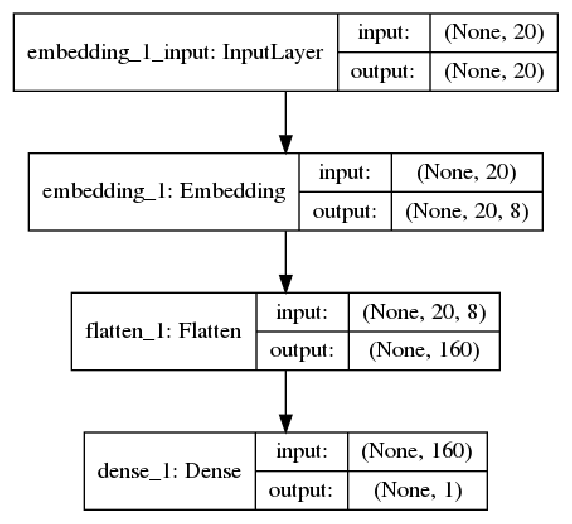

In [8]:
import matplotlib.pyplot as plt
img_path = './Dataset/model.png'
#plot_model(model,show_shapes=True,to_file=img_path)

img = cv2.imread(img_path)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)

### 모델의 성능을 최대로 끌어올리기
모델의 성능을 올리기 위한 몇가지 대표적인 방법에 대하여 간단하게 알아보자.  

#### 배치 정규화
<a href="https://wjddyd66.github.io/dl/NeuralNetwork-(5)-Others/">NeuralNetwork(5) 학습 관련 기술들</a>에서 다양한 Model의 성능을 향상시키는 방법에 대해서 알아보았다.  
그 중 가장먼저 사용하는 배치 정규화에 대해서만 알아보자.  
배치 정규화는 그림으로 나타내면 다음과 같다.  
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&amp;fname=http%3A%2F%2Fcfile29.uf.tistory.com%2Fimage%2F994586445BBE000E15CC3D" height="250" width="600"><br>
배치 정규화의 이점으로는 3가지를 소개하였었다.  
1. 학습을 빨리 진행할 수 있다.(학습 속도 개선)
2. 초기값에 크게 의존하지 않는다.
3. 오버피팅을 억제한다.

배치 정규화에 대한 수식이나 자세한 사항은 위의 링크를 참조하고 Keras에서는 <code>layers.BatchNormalization()</code>이라는 Layer 추가 만으로 간단히 BatchNormalization을 수행할 수 있다.  

<br><br>

#### 분리 합성곱
OpenCV에서 Filter를 통하여 Image처리를 할때 예를들어 사람의 얼굴을 판단하거나 손을 Detection하는 경우 가장 많이 사용하였던것이 RGB의 Image를 HSV로서 변환시키고 각각의 Channel에 대한 Filter를 거치고 Threshold를 사용하여 판별하였다.  
Keras에서도 이러한 분리 합성곱을 모델의 성능을 향상시키는 방법중 하나라고 이야기한다.  
이러한 구조를 **깊이변 분리 합성곱(depthwise separable convolution)** 이라고 소개한다.  
그림으로 나타내면 아래와 같다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/56.png" height="100%" width="100%" /></div><br>
사진 출처: <a href="https://subinium.github.io/Keras-7/#716-%EC%B8%B5%EA%B3%BC-%EB%AA%A8%EB%8D%B8">subinium 블로그</a><br>
위와 같은 구조를 나타내기 위하여 Image를 각각의 Channel별로 나누는 전처리 후 함수 API로서 각각의 Network를 따로 구현하는 것이 아닌<code>keras.layers.SeparableConv2D()</code>로서 제공한다.  
> Separable convolution performs first a depthwise spatial convolution (which acts on each input channel separately) followed by a pointwise convolution which mixes together the resulting output channels. The depth_multiplier argument controls how many output channels are generated per input channel in the depthwise step.

위의 설명을 간단하게 나타낸 그림을 살펴보면 다음과 같다.  
<img src="https://miro.medium.com/max/1308/1*yG6z6ESzsRW-9q5F_neOsg.png"><br>
그림 참조: <a href="https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728"></a>

In [12]:
height = 64
width = 64
channels = 3
num_classes = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_3 (Separabl (None, 62, 62, 32)        155       
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 60, 60, 64)        2400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
separable_conv2d_6 (Separabl (None, 26, 26, 128)       8896      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 11, 11, 64)      

#### 모델 앙상블
모델 앙상블(model ensemble)은 여러 개 다른 모델의 예측을 합쳐 더 좋은 예측을 만드는 기법이다.  
즉, 분류기의 다양성을 주어서 모델이 서로 다른 방향으로 편향되어있는 것을 상쇄시켜 더 정확한 모델을 찾아내는 방식이다.  
예를 들어 동물을 예측하는 분류기를 만든다고 하는 경우 동물의 전체 Image자체를 Input으로 넣고 Training하는 것이아닌 동물의 다리를 판별하는 Model + 동물의 눈동자를 보고 판별하는 Model + ... 등으로서 Model을 구성하고 합치는 방식을 선택하는 것 이다.  

이러한 방식에서 중요한 점은 **분류기 중 하나가 다른 모델보다 월등히 나쁘면 최종 예측은 앙상블에 있는 가장 좋은 분류기만 사용하는 것 보다 나쁠 수 있다.**  

즉, 사용하는 분류기들의 성능이 어느정도 나와있다고 검증해야지 사용할 수 있는 방법이다.  

최종적인 Prediction을 구하는 방법은 각각의 분류기의 Prediction에서 가중치를 주어서 구할 수 있다.

In [ ]:
# 분류기가 4개이고 각각의 성능이 좋다고 검증 완료 되었다고 가정
preds_a = model_a.predict(x_val)
preds_b = model_a.predict(x_val)
preds_c = model_a.predict(x_val)
preds_d = model_a.predict(x_val)

# 4개의 분류기의 Prediction을 가중치를 주어서 최종적인 Prediction 구함
final_preds = 0.5*preds_a + 0.25*preds_b + 0.1*preds_c + 0.15*preds_d

#### Hyperparameter Tuning
<a href="https://wjddyd66.github.io/kubeflow/Kubeflow(8)/">Katib</a>에서는 Kubeflow에서 Katib를 활용하여 Tensorflow의 Hyperparameter를 Tuning하였다.  
Keras도 지원한다고 하여 Googling을 하였지만 한계점이 존재하였다.  
<a href="https://github.com/keras-team/keras-tuner">Keras Github</a>에서 Keras Tuner라고 Hyperparameter Tuning을 지원하나 다음과 같은 제약사향이 요구된다.  

**Requirements**  
- Pthon 3.6
- Tensorflow 2.0

현재 Tensorflow는 1.x Version이므로 결과를 확인하지는 못하였다.